In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [7]:
# Circle: returns true if (px, py) is inside the circle of radius r centered at (cx, cy)
circle_mask(px, py, cx, cy, r) = (px - cx)^2 + (py - cy)^2 <= r^2

# Cross: returns true if (px, py) is within the cross arms centered at (cx, cy) with arm length size and thickness t
function cross_mask(px, py, cx, cy, size, t)
    half = size / 2
    # Horizontal arm
    in_h = abs(py - cy) <= t/2 && abs(px - cx) <= half
    # Vertical arm
    in_v = abs(px - cx) <= t/2 && abs(py - cy) <= half
    return in_h || in_v
end

# Rasterize a random shape to a grid array
function raster_random_shape(rng::AbstractRNG; canvas_size=10, grid_size=128, cross_thickness=0.2)
    shape_type = rand(rng, ["cross", "circle"])
    vmap = Dict("cross" => 1, "circle" => 2)
    x = rand(rng) * canvas_size
    y = rand(rng) * canvas_size
    size = (0.5 + rand(rng)) * (canvas_size / 5)
    t = cross_thickness * size

    # Set up grid coordinates (center of each pixel)
    xs = range(0, canvas_size, length=grid_size)
    ys = range(0, canvas_size, length=grid_size)
    img = zeros(Float32, grid_size, grid_size, 1)

    for j in 1:grid_size, i in 1:grid_size
        px, py = xs[i], ys[j]
        if shape_type == "circle"
            img[j, i, 1] = circle_mask(px, py, x, y, size/2) ? 1 : 0
        else
            img[j, i, 1] = cross_mask(px, py, x, y, size, t) ? 1 : 0
        end
    end
    return img, vmap[shape_type]
end

raster_random_shape (generic function with 1 method)

In [8]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [9]:
args = Args(batchsize = 128, epochs = 25)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [10]:
function generate_dataset(rng::AbstractRNG, n::Int, args::Args)
    data = [raster_random_shape(rng) for i in 1:n];
    x = stack([d[1] for d in data]);
    y = onehotbatch(stack([d[2] for d in data]), 1:2);
    loader = DataLoader((x, y), batchsize = args.batchsize)
    return loader
end

generate_dataset (generic function with 1 method)

In [11]:
train_loader = generate_dataset(rng, 10000, args)

79-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [12]:
x0, y0 = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 1 1 … 1 1])

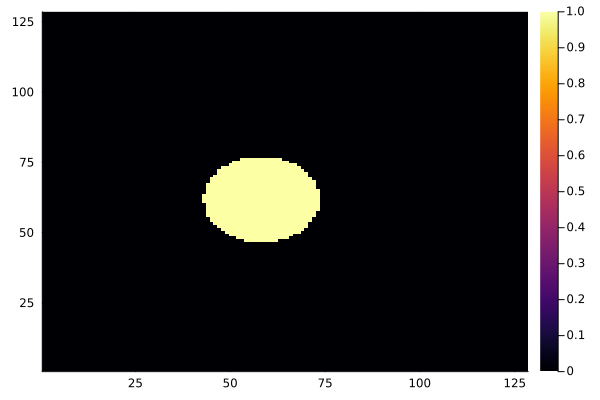

In [13]:
heatmap(x0[:,:,1,1])

In [14]:
y0[:,1]

2-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 1

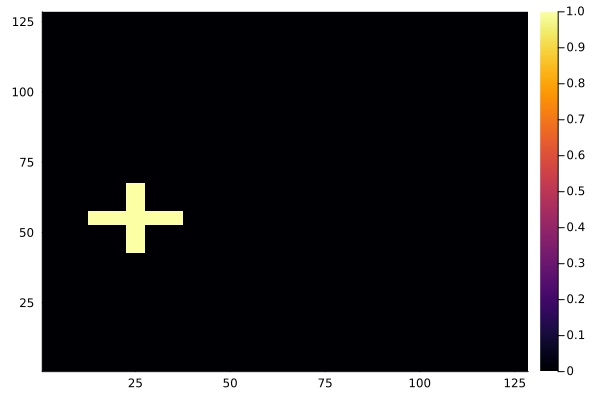

In [15]:
heatmap(x0[:,:,1,5])

In [16]:
y0[:,5]

2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

In [17]:
model = Chain(Conv((32,32), 1=>3, relu, pad=(1,1)),
            MaxPool((2,2)),
            Dropout(0.3),

            Conv((16,16), 3=>1, relu, pad=(1,1)),
            MaxPool((2,2)),
            FlattenLayer(),
            Dropout(0.4),

            Dense(324 => 16, relu),
            Dense(16 => 2),
            softmax)

Chain(
    layer_1 = Conv((32, 32), 1 => 3, relu, pad=1),  # 3_075 parameters
    layer_2 = MaxPool((2, 2)),
    layer_3 = Dropout(0.3),
    layer_4 = Conv((16, 16), 3 => 1, relu, pad=1),  # 769 parameters
    layer_5 = MaxPool((2, 2)),
    layer_6 = FlattenLayer{Nothing}(nothing),
    layer_7 = Dropout(0.4),
    layer_8 = Dense(324 => 16, relu),   # 5_200 parameters
    layer_9 = Dense(16 => 2),           # 34 parameters
    layer_10 = WrappedFunction(softmax),
)         # Total: 9_078 parameters,
          #        plus 4 states.

In [18]:
ps, st = Lux.setup(rng, model) .|> gdev

((layer_1 = (weight = Float32[0.0647331 -0.090335414 … -0.06623472 -0.0882138; 0.104248665 0.107993685 … 0.05510278 -0.058171876; … ; -0.007700065 0.08978369 … -0.06908216 0.044815887; 0.06277446 -0.07924805 … 0.0782236 0.0055098007;;;; 0.0078999605 0.08269163 … 0.07409875 -0.08248973; -0.058716923 0.013010319 … -0.029206622 0.0871948; … ; -0.09647753 -0.099848635 … -0.018900966 -0.09327733; -0.08953515 0.07909816 … 0.064854644 -0.1060345;;;; 0.06571025 -0.0012832775 … -0.103039 -0.024683781; 0.078905724 -0.048005536 … -0.10359778 -0.09161592; … ; -0.008314397 -0.08115026 … -0.027980423 0.058908455; -0.03306411 -0.06863046 … 0.06234417 0.06124875], bias = Float32[0.025551282, 0.028959043, 0.02966293]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.021002993 -0.11080849 … -0.04849969 -0.09852825; 0.05307427 -0.05542408 … 0.11395268 -0.012901396; … ; -0.11782649 -0.10214096 … 0.025629565 -0.12043695; 0.00559777 -0.11550431 … -0.045852885 -0.04244259;;; -0

In [19]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y)
end

loss_function (generic function with 1 method)

In [20]:
x0 = x0 |> gdev
y0 = y0 |> gdev

2×128 OneHotMatrix(::CuArray{UInt32, 1, CUDA.DeviceMemory}) with eltype Bool:
 ⋅  ⋅  1  1  1  1  1  1  ⋅  ⋅  ⋅  1  ⋅  …  1  1  1  1  1  1  ⋅  1  ⋅  1  ⋅  ⋅
 1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  1

In [21]:
l, gs = withgradient(p -> loss_function(x0, y0, model, p, st), ps)

(val = 1.3063099f0, grad = ((layer_1 = (weight = Float32[0.13813864 0.13715017 … 0.01373155 0.021164985; 0.14778188 0.14680675 … 0.035400115 0.02412005; … ; -0.010096599 -0.012835161 … -0.007374837 0.025130786; -0.009013151 -0.0044313436 … 0.016934581 0.024030112;;;; 0.11550743 0.11307618 … 0.15023458 0.14438435; 0.100666985 0.09968167 … 0.17353347 0.16161194; … ; 0.0062672216 0.0067614885 … 0.08831501 0.08800185; 0.005139717 0.01622812 … 0.081013285 0.072032146;;;; 0.14321457 0.1220994 … 0.03970345 0.034767345; 0.15036839 0.13104686 … 0.03606374 0.033844057; … ; 0.17560273 0.18127596 … 0.033922553 0.04322593; 0.17904523 0.1832962 … 0.05987633 0.05933025], bias = Float32[-0.02864936, 0.7349499, 1.0254072]), layer_2 = nothing, layer_3 = nothing, layer_4 = (weight = Float32[0.3173682 0.28047162 … 0.18836936 0.15471244; 0.43547916 0.3241102 … 0.1527937 0.0988836; … ; 0.30180115 0.22963399 … 0.22638792 0.26030856; 0.27322158 0.24762407 … 0.1947207 0.18451977;;; 0.08768683 0.06772128 … 0.06

In [22]:
#losses, pst, stt = train(model, ps, st, train_loader, loss_function, args)

In [23]:
#plot(losses)

In [25]:
#yh1, _ = model(x0, pst, stt)

In [26]:
test_loader = generate_dataset(rng, 1000, args)

8-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [27]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        true_labels = onecold(y)
        
        total_correct += sum(pred_labels .== true_labels)
        total_samples += size(x, 4)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [28]:
test(model, test_loader, ps, st)

┌ Warning: `training` is set to `Val{true}()` but is not being used within an autodiff call (gradient, jacobian, etc...). This will be slow. If you are using a `Lux.jl` model, set it to inference (test) mode using `LuxCore.testmode`. Reliance on this behavior is discouraged, and is not guaranteed by Semantic Versioning, and might be removed without a deprecation cycle. It is recommended to fix this issue in your code.
└ @ LuxLib.Utils ~/.julia/packages/LuxLib/Kj0os/src/utils.jl:334


0.484

In [29]:
#test(model, test_loader, pst, stt)

# Replicate with Phasor Architecture

In [30]:
import Base.show

In [31]:
struct ComplexBias <: LuxCore.AbstractLuxLayer
    dims
    init_bias
end

function ComplexBias(dims::Tuple{Vararg{Int}}; init_bias = nothing)
    if init_bias == nothing
        init_bias = (rng, dims) -> ones(ComplexF32, dims)
    end

    return ComplexBias(dims, init_bias)
end

function Base.show(io::IO, b::ComplexBias)
    print(io, "ComplexBias($(b.dims))")
end

In [32]:
import .PhasorNetworks: LuxParams

In [33]:
function (b::ComplexBias)(x::AbstractArray{<:Complex}, params::LuxParams, state::NamedTuple)
    b = params.bias_real .+ 1.0f0im .* params.bias_imag
    return x .+ b
end

In [34]:
function (b::ComplexBias)(params::LuxParams, state::NamedTuple; offset::Real = 0.0, spk_args::SpikingArgs)
    b = params.bias_real .+ 1.0f0im .* params.bias_imag
    return t -> bias_current(b, t, offset, spk_args)
end


In [35]:
function Lux.initialparameters(rng::AbstractRNG, bias::ComplexBias)
    bias = bias.init_bias(rng, bias.dims)
    bias_real = real.(bias)
    bias_imag = imag.(bias)
    params = (bias_real = bias_real, bias_imag = bias_imag)
    return params
end

In [36]:
ComplexBias((1,2,4), init_bias=nothing)

ComplexBias((1, 2, 4))  # 16 parameters

In [37]:
# TODO - refactor "return solution" into layer calls, not fields

In [38]:
struct PhasorConv <: LuxCore.AbstractLuxContainerLayer{(:conv, :bias)}
    conv
    bias
end

In [39]:
function PhasorConv(k::Tuple{Vararg{<:Integer}}, chs::Pair{<:Integer,<:Integer}; init_bias = nothing, kwargs...)
    #construct the convolutional layer
    conv = Conv(k, chs, identity; kwargs...)
    bias = ComplexBias((k..., chs[2]), init_bias = init_bias)
    return PhasorConv(conv, bias)
end

PhasorConv

In [40]:
pcl = PhasorConv((32, 32), 1 => 3)

PhasorConv(
    conv = Conv((32, 32), 1 => 3),      # 3_075 parameters
    bias = ComplexBias((32, 32, 3)),    # 6_144 parameters
)         # Total: 9_219 parameters,
          #        plus 0 states.

In [38]:
function (pc::PhasorConv)(x, ps, st)
    x = angle_to_complex(x)
    x_real = real.(x)
    x_imag = imag.(x)

    conv_call = x -> pc.conv(x, ps.conv, st.conv)[1]
    y_real = conv_call(x_real)
    y_im = 1.0f0im .* conv_call(x_imag)
    y = y_real .+ y_im
    y = pc.bias(y, ps.bias, st.bias)
    y = complex_to_angle(y)
    
    return y, NamedTuple()
end

In [76]:
pcl.conv

Conv((32, 32), 1 => 3)  # 3_075 parameters

In [77]:
m1 = Chain(PhasorConv((32, 32), 1 => 3),)

Chain(
    layer_1 = PhasorConv(
        conv = Conv((32, 32), 1 => 3),  # 3_075 parameters
    ),
)         # Total: 3_075 parameters,
          #        plus 0 states.

In [79]:
cx0 = angle_to_complex(x0 .* 0.5f0);

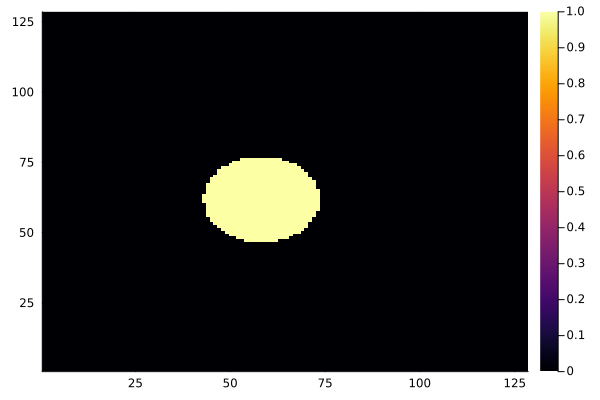

In [80]:
heatmap(imag.(cdev(cx0[:,:,1,1])))

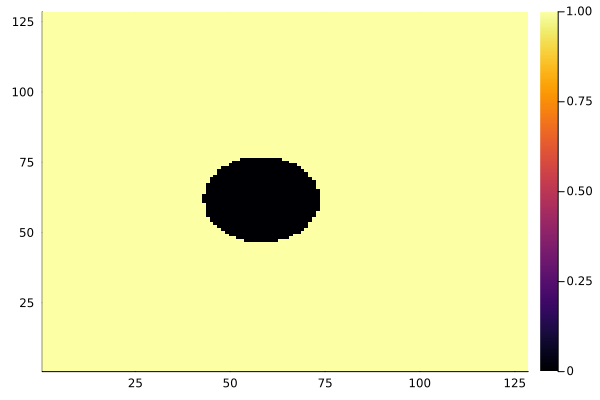

In [81]:
heatmap(real.(cdev(cx0[:,:,1,1])))

In [82]:
psp, stp = Lux.setup(rng, m1) .|> gdev

((layer_1 = (weight = Float32[-0.0055078845 -0.05363229 … -0.031974956 -0.017698582; -0.031537484 0.052181266 … -0.037682544 0.028229654; … ; -0.04066181 -0.041969784 … 0.022369185 0.012932451; 0.015603329 0.04753641 … -0.0042467387 -0.012214436;;;; -0.019860508 0.0018494814 … 0.025311308 0.009751312; 0.03494641 0.012231728 … 0.038689964 0.05219541; … ; -0.011575365 -0.010667604 … 0.04378465 0.042279538; -0.029270947 0.04210347 … 0.022513557 0.046255235;;;; 0.049620796 -0.036486275 … -0.041560657 0.0031411664; -0.03808303 -0.04416012 … -0.010845613 0.027163977; … ; 0.024941314 -0.04919678 … 0.03370778 -0.009472254; 0.023239238 -0.047844753 … 0.04664782 0.016429273], bias = Float32[-0.015690077, -0.021580927, 0.012635309]),), (layer_1 = NamedTuple(),))

In [84]:
yp0, stp0 = m1(x0 .* 0.5f0, psp, stp)

(Float32[-0.024390176 -0.024390193 … -0.024390262 -0.024390254; -0.02439016 -0.024390148 … -0.024390206 -0.024390223; … ; -0.024390213 -0.024390193 … -0.024390196 -0.024390206; -0.024390196 -0.024390204 … -0.024390236 -0.024390228;;; -0.0058656274 -0.0058656246 … -0.005865644 -0.0058656405; -0.0058656265 -0.005865623 … -0.005865633 -0.005865629; … ; -0.005865631 -0.005865632 … -0.0058656414 -0.005865643; -0.005865633 -0.005865636 … -0.0058656414 -0.00586564;;; 0.014685267 0.014685253 … 0.014685217 0.0146852285; 0.014685253 0.01468525 … 0.014685211 0.014685223; … ; 0.014685196 0.014685188 … 0.014685215 0.014685217; 0.014685249 0.014685252 … 0.014685247 0.01468525;;;; -0.024390083 -0.024390064 … -0.024390195 -0.02439021; -0.024390187 -0.024390195 … -0.024390152 -0.024390163; … ; -0.024390066 -0.024390083 … -0.024390206 -0.024390223; -0.02439015 -0.024390161 … -0.024390135 -0.024390152;;; -0.0058656135 -0.0058656116 … -0.0058656377 -0.0058656405; -0.005865624 -0.0058656135 … -0.0058656307

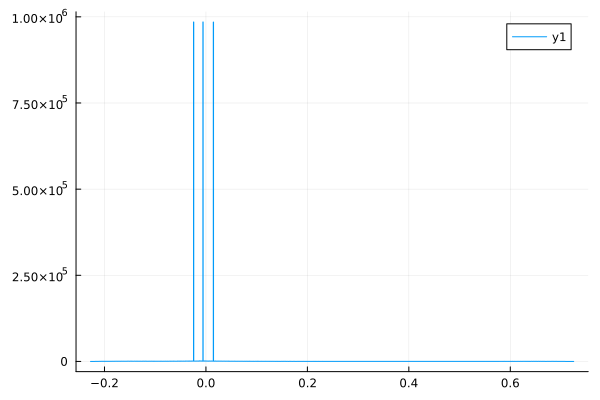

In [85]:
histogram(cdev(vec(yp0)))

In [87]:
p_model = Chain(
            x -> 0.5f0 .* x,
            PhasorConv((32,32), 1=>3, pad=(1,1)),
            MeanPool((2,2)),
            Dropout(0.3),

            PhasorConv((16,16), 3=>1, pad=(1,1)),
            MeanPool((2,2)),
            FlattenLayer(),
            Dropout(0.4),

            PhasorDense(324 => 16,),
            PhasorDense(16 => 2),
            )

Chain(
    layer_1 = WrappedFunction(#12),
    layer_2 = PhasorConv(
        conv = Conv((32, 32), 1 => 3, pad=1),  # 3_075 parameters
    ),
    layer_3 = MeanPool((2, 2)),
    layer_4 = Dropout(0.3),
    layer_5 = PhasorConv(
        conv = Conv((16, 16), 3 => 1, pad=1),  # 769 parameters
    ),
    layer_6 = MeanPool((2, 2)),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = Dropout(0.4),
    layer_9 = PhasorDense((324, 16)),   # 5_216 parameters
    layer_10 = PhasorDense((16, 2)),    # 36 parameters
)         # Total: 9_096 parameters,
          #        plus 4 states.

In [88]:
pps, pst = Lux.setup(rng, p_model) .|> gdev

((layer_1 = NamedTuple(), layer_2 = (weight = Float32[-0.021946333 0.009224681 … 0.042968012 -0.048435815; -0.03203607 0.008207358 … -0.003849084 0.039201677; … ; -0.045447733 0.049657162 … -0.049352553 -0.005891131; -0.009710114 0.026849331 … 0.011711233 0.02118113;;;; 0.021451345 0.024459798 … -0.017058853 -0.010169293; -0.0068930387 -0.019547462 … 0.042181104 0.009876735; … ; 0.016918048 -0.046360068 … -0.021914968 0.03216408; 0.04328383 0.04925884 … -0.045782488 -0.046458416;;;; 0.03861369 0.053478178 … -0.04214321 0.022673724; 0.010094612 0.053402655 … -0.03267601 0.014007665; … ; 0.012238723 0.04469386 … -0.011268929 0.013010881; -0.009992394 0.03771707 … -0.0048974236 0.00024232603], bias = Float32[-0.027639858, -0.017535862, 0.014892414]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (weight = Float32[0.05921661 -0.005219154 … -0.040327244 -0.06143836; -0.050673686 -0.037746474 … -0.053345174 -0.051706612; … ; 0.06146033 -0.018557273 … 0.007806234 0.04760658; 0.055

In [91]:
yhp0, _ = p_model(x0, pps, pst)

(Float32[0.11490297 0.013193907 … -0.0029494525 0.10675902; -0.046465125 -0.05649558 … -0.0950477 -0.11961941], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (rng = Xoshiro(0x5d079451407505af, 0xf6825ddbaf79c734, 0x917711937f61e59f, 0x2300e6d6c35b094c, 0xc90c4a0730db3f7e), training = Val{true}()), layer_5 = NamedTuple(), layer_6 = NamedTuple(), layer_7 = NamedTuple(), layer_8 = (rng = Xoshiro(0x88852f5c2c57cbd7, 0x3af2d819906d2704, 0x77c7db31b17ce030, 0x59cf1ab05761ad84, 0xc90c4a0730db3f7e), training = Val{true}()), layer_9 = NamedTuple(), layer_10 = NamedTuple()))

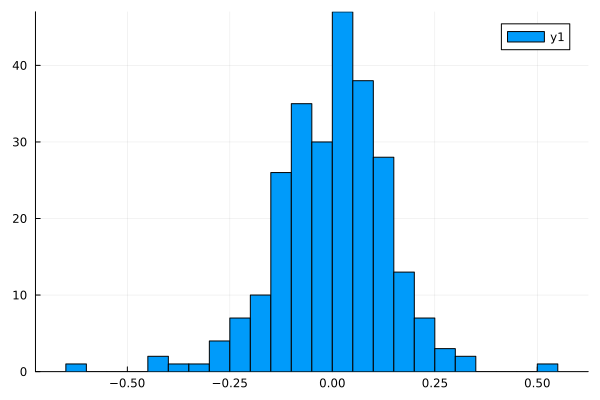

In [92]:
histogram(vec(cdev(yhp0)))

In [93]:
quadrature_loss(yhp0, y0) |> mean

0.5353942f0

In [94]:
function phasor_loss_function(x, y, model, ps, st, scale::Real=3.0f0)
    y_pred, _ = Lux.apply(model, x, ps, st)
    loss = quadrature_loss(y_pred, y) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 2 methods)

In [95]:
l2, gs2 = withgradient(p -> phasor_loss_function(x0, y0, p_model, p, pst), pps)

(val = 0.5353942f0, grad = ((layer_1 = nothing, layer_2 = (weight = Float32[-0.0028227172 -0.004612566 … 0.0014676251 0.0018652845; -0.0030111354 -0.004514133 … 0.00066690985 0.0010459376; … ; -0.010566435 -0.011846345 … 0.0048846505 0.0048061674; -0.010019436 -0.009276271 … 0.0047551272 0.0047957487;;;; -0.008207269 -0.009242205 … 0.0040448606 0.0043259608; -0.007878069 -0.008954005 … 0.0052648587 0.0050805514; … ; 0.0047330568 0.0042126495 … 0.012759058 0.011140619; 0.005365258 0.0056016333 … 0.010412408 0.008903081;;;; -0.00056390185 -0.0003617215 … 0.0013468761 0.0071472693; -0.000661456 -0.0037961137 … 0.0013118642 0.0061477604; … ; 0.026625585 0.024696188 … -0.001207293 -0.001202723; 0.024163079 0.023000028 … -0.002004413 -0.002246569], bias = Float32[-0.016095452, 0.00919416, 0.010534411]), layer_3 = nothing, layer_4 = nothing, layer_5 = (weight = Float32[0.013074109 0.016571593 … 0.04296697 0.03811483; 0.008236392 0.009553271 … 0.048021596 0.024643991; … ; 0.0005011624 0.016102

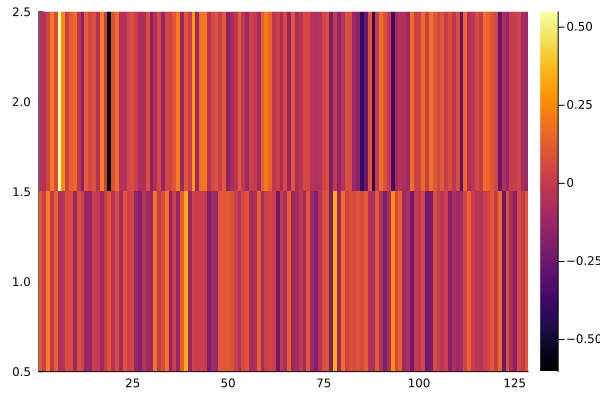

In [97]:
heatmap(yhp0 |> cdev)

In [101]:
p_losses, ppst, pstp = train(p_model, pps, pst, train_loader, phasor_loss_function, args, optimiser=Optimisers.RMSProp)

[ Info: Training on CUDA GPU


(Any[0.5353942f0, 0.51495695f0, 0.5152656f0, 0.52936435f0, 0.5410826f0, 0.51955926f0, 0.514283f0, 0.5417213f0, 0.5315329f0, 0.52172506f0  …  0.2016958f0, 0.17889032f0, 0.19908233f0, 0.19761164f0, 0.18499239f0, 0.15354335f0, 0.16818325f0, 0.227844f0, 0.21022485f0, 0.15059763f0], (layer_1 = NamedTuple(), layer_2 = (weight = Float32[-0.040270414 -0.008739579 … 0.045192767 -0.05294261; -0.03958401 0.0016143547 … -0.010561043 0.021814326; … ; -0.044687904 0.050586935 … -0.05060632 -0.008319469; -0.009171757 0.028301522 … 0.009616596 0.018514112;;;; 0.040088877 0.044251706 … -0.0074435123 0.0013351509; 0.009548035 -0.0024654549 … 0.050088294 0.019233797; … ; 0.007669025 -0.049996935 … 0.0013941593 0.05471181; 0.030301677 0.041723505 … -0.020517703 -0.02162649;;;; 0.016679335 0.03337763 … -0.02994679 0.034529977; -0.014115352 0.030554386 … -0.025507113 0.021239553; … ; 0.021288825 0.05240131 … -0.01672349 0.014997342; 0.0006717638 0.046687584 … -0.01612658 -0.0062960605], bias = Float32[-0.01

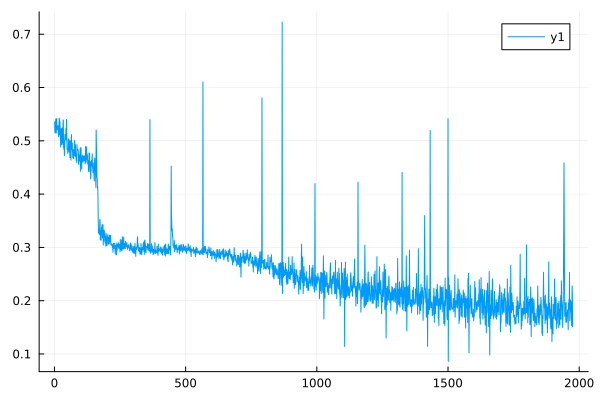

In [102]:
plot(p_losses)

In [103]:
yhp1, _ = p_model(x0, ppst, pstp)

(Float32[-0.02708591 0.08109604 … 0.41901404 0.2559901; 0.34806383 0.51985353 … 0.1325795 0.18997894], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (rng = Xoshiro(0x5d079451407505af, 0xf6825ddbaf79c734, 0x917711937f61e59f, 0x2300e6d6c35b094c, 0xc90c4a0730db3f7e), training = Val{true}()), layer_5 = NamedTuple(), layer_6 = NamedTuple(), layer_7 = NamedTuple(), layer_8 = (rng = Xoshiro(0x88852f5c2c57cbd7, 0x3af2d819906d2704, 0x77c7db31b17ce030, 0x59cf1ab05761ad84, 0xc90c4a0730db3f7e), training = Val{true}()), layer_9 = NamedTuple(), layer_10 = NamedTuple()))

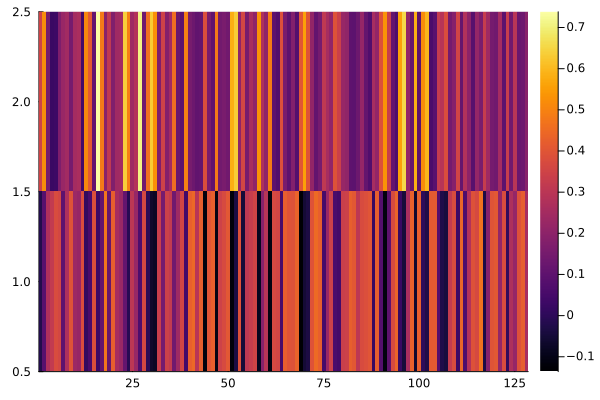

In [104]:
heatmap(yhp1 |> cdev)

In [105]:
loss_and_accuracy(test_loader, p_model, ppst, pstp, args)

(0.1976172f0, 0.788)